In [1]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install google-cloud-language
!pip install matplotlib
!pip install swifter
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 132.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 153.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.0/462.0 kB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 55.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 10.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 16.7 MB/s eta 0:00:0

In [2]:
import pandas as pd


In [77]:
fb = pd.read_csv("fb-israeli-pages-with-text.csv.gz") #3,931,344 מס שורות

/tmp/ipykernel_76/1895396563.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  fb = pd.read_csv("fb-israeli-pages-with-text.csv.gz") #3,931,344 מס שורות


In [10]:
fb = fb[~fb['message'].apply(contains_arabic)]
fb_hebrew =  fb[~fb['message'].apply(contains_english)]
fb.shape[0]
fb_hebrew.shape[0] #1,455,921

1455921

In [7]:
fb_hebrew = pd.read_csv("fb_hebrew") 

In [9]:
# המרת עמודת התאריך לפורמט datetime
fb_hebrew['date'] = pd.to_datetime(fb_hebrew['date'])
# הגדרת טווח התאריכים
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("2018-12-31")
# סינון הנתונים לפי התאריכים
fb_hebrew_14_18 = fb_hebrew[(fb_hebrew['date'] >= start_date) & (fb_hebrew['date'] < end_date)]
# איפוס אינדקס ושמירת התוצאה כ-DataFrame חדש
fb_hebrew_14_18 = fb_hebrew_14_18.reset_index(drop=True)
# הצגת התוצאה
fb_hebrew_14_18.shape[0]#222,400

715419

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import swifter

# Load HeBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT_sentiment_analysis")
model = AutoModelForSequenceClassification.from_pretrained("avichr/heBERT_sentiment_analysis", num_labels=3)

# Define sentiment analysis pipeline
sentiment_analysis = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True)
# Function to adjust predictions based on threshold
def adjust_predictions(predictions, threshold=0.987):
    adjusted_predictions = [
        max(pred, key=lambda x: x['score']) if max(pred, key=lambda x: x['score'])['score'] >= threshold
        else {'label': 'neutral', 'score': max(pred, key=lambda x: x['score'])['score']}
        for pred in predictions
    ]
    return adjusted_predictions
# Apply sentiment analysis to a DataFrame
def process_dataframe(df, text_column, threshold=0.987):
    # Run sentiment analysis on all rows in batches
    df['sentiment_scores'] = sentiment_analysis(df[text_column].tolist())
    # Adjust predictions based on the threshold
    df['adjusted_sentiments'] = adjust_predictions(df['sentiment_scores'])
    # Extract adjusted labels and scores
    df['adjusted_label'] = df['adjusted_sentiments'].apply(lambda x: x['label'])
    df['adjusted_score'] = df['adjusted_sentiments'].apply(lambda x: x['score'])
    return df

# Optional: Map sentiment to numerical scores (if needed)
def map_sentiment_to_score(label):
    mapping = {'positive': 0, 'negative': 1, 'neutral': 2}
    return mapping.get(label, None)

# Example usage
# fb_hebrew = process_dataframe(fb_hebrew, 'text_column_name', threshold=0.987)


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
/opt/conda/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [10]:
fb_hebrew_14_18 = process_dataframe(fb_hebrew_14_18, text_column='message', threshold=0.987)

NameError: name 'fb_hebrew_2020_end' is not defined

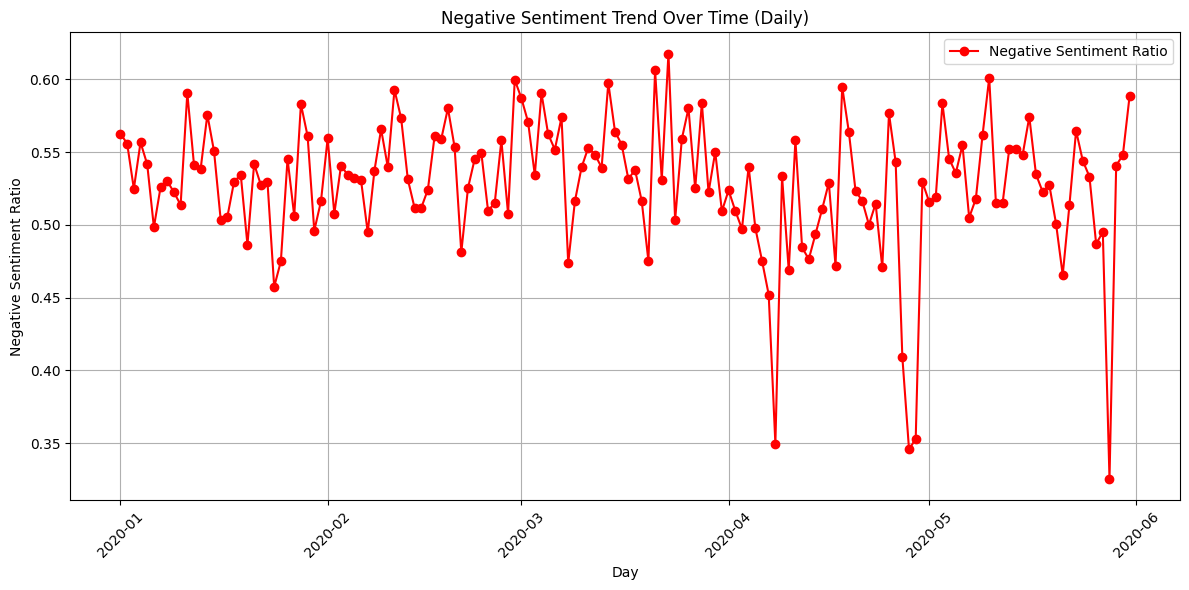

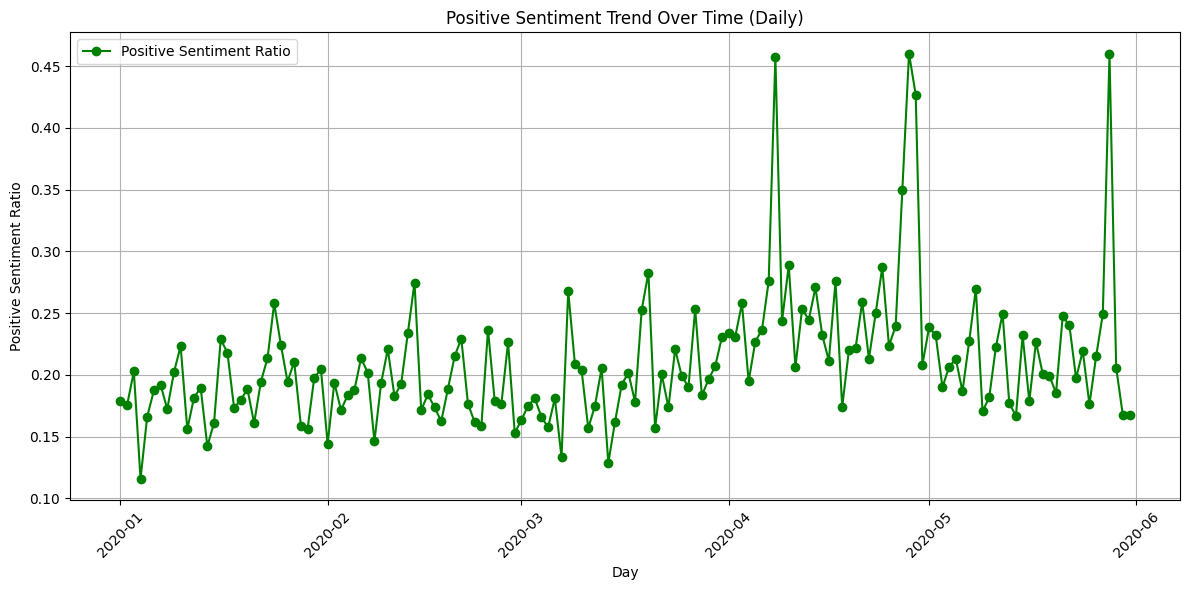

                 date                                            message  \
0 2020-01-01 23:10:35  אחרי המלים מגיעים גם מספרים כך נראתה הליגה לפנ...   
1 2020-01-01 23:03:08  הדרך מהצפון הביתה מעולם לא היתה שמחה יותר  כמו...   
2 2020-01-01 23:01:23  הקריימיניסטר גאנג מברכת את בנימין נתניהו לכבוד...   
3 2020-01-01 23:00:04  אני רוצה שכל הבנות שצופות בנו עכשיו ידעו שיש י...   
4 2020-01-01 22:24:48                אני אחרי האי נעימות המינימלית ביותר   

                                           sentiment adjusted_label  \
0  [[{'label': 'neutral', 'score': 0.000148318475...       negative   
1  [[{'label': 'neutral', 'score': 6.608837429666...       negative   
2  [[{'label': 'neutral', 'score': 0.000199861300...        neutral   
3  [[{'label': 'neutral', 'score': 6.189133273437...       negative   
4  [[{'label': 'neutral', 'score': 0.001014359411...       negative   

   adjusted_score  score  real score          day  negative_ratio_x  \
0        0.999817      1            1  2020-0

In [53]:
import matplotlib.pyplot as plt
# המרת עמודת התאריך לפורמט datetime (אם עדיין לא בוצע)
fb_hebrew_2020['date'] = pd.to_datetime(fb_hebrew_2020['date'])
# הוספת עמודת יום (העתק של עמודת התאריך ללא זמן)
fb_hebrew_2020['day'] = fb_hebrew_2020['date'].dt.date
# חישוב כמות הפוסטים לפי סנטימנט בכל יום
sentiment_counts_daily = fb_hebrew_2020.groupby(['day', 'adjusted_label']).size().unstack(fill_value=0)
# חישוב סך הפוסטים ויחסי הפוסטים החיוביים והשליליים
sentiment_counts_daily['total'] = sentiment_counts_daily.sum(axis=1)
sentiment_counts_daily['negative_ratio'] = sentiment_counts_daily['negative'] / sentiment_counts_daily['total']
sentiment_counts_daily['positive_ratio'] = sentiment_counts_daily['positive'] / sentiment_counts_daily['total']

# מיזוג עמודות היחסים עם הטבלה המקורית
fb_hebrew_2020 = fb_hebrew_2020.merge(
    sentiment_counts_daily[['negative_ratio', 'positive_ratio']].reset_index(),
    how='left',
    left_on='day',
    right_on='day')
# גרף מגמת הפוסטים השליליים
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts_daily.index, sentiment_counts_daily['negative_ratio'], marker='o', label='Negative Sentiment Ratio', color='red')
plt.title('Negative Sentiment Trend Over Time (Daily)')
plt.xlabel('Day')
plt.ylabel('Negative Sentiment Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# גרף מגמת הפוסטים החיוביים
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts_daily.index, sentiment_counts_daily['positive_ratio'], marker='o', label='Positive Sentiment Ratio', color='green')
plt.title('Positive Sentiment Trend Over Time (Daily)')
plt.xlabel('Day')
plt.ylabel('Positive Sentiment Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [75]:
fb_hebrew_2020 = pd.read_excel("fb_hebrew_2020(01-06).xlsx") 
ta_35_all = pd.read_excel("ta_35_all.xlsx") 

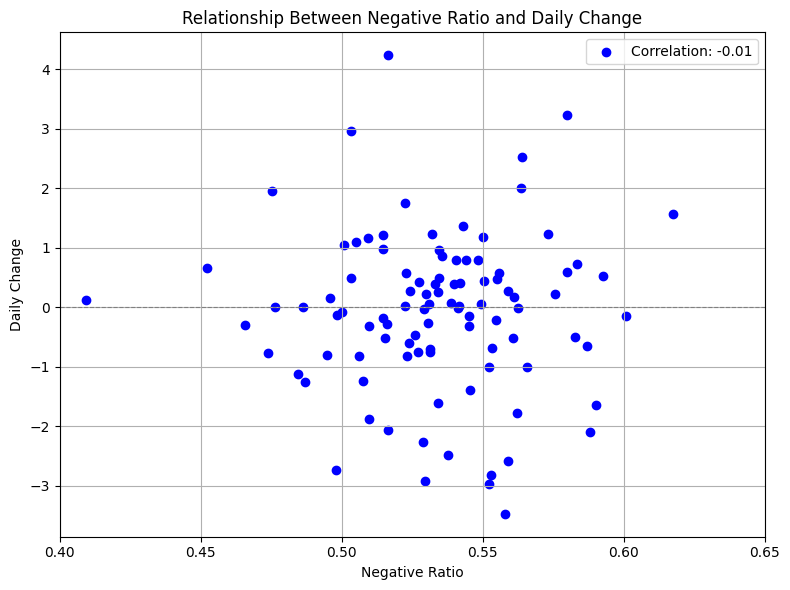

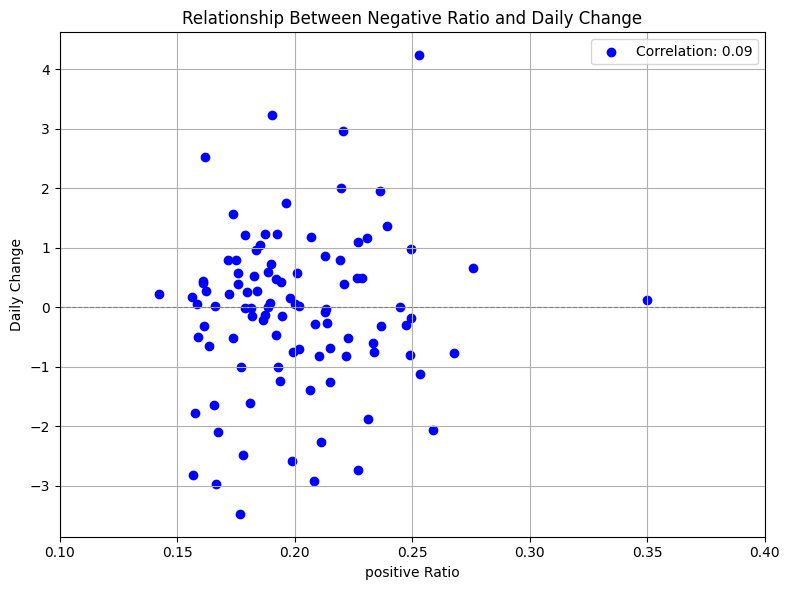

Correlation between Negative Ratio and Daily Change: -0.01
Correlation between Negative Ratio and Daily Change: 0.09


In [74]:
# חישוב קורלציה בין שינוי יומי ל-negative_ratio
correlation_n = ta_35_all['שינוי יומי'].corr(ta_35_all['negativ_ratio'])
correlation_p = ta_35_all['שינוי יומי'].corr(ta_35_all['positive_ratio'])
# יצירת גרף הקשר בין שינוי יומי ל-negative_ratio
plt.figure(figsize=(8, 6))
plt.scatter(ta_35_all['negativ_ratio'], ta_35_all['שינוי יומי'], color='blue', label=f"Correlation: {correlation_n:.2f}")
plt.title('Relationship Between Negative Ratio and Daily Change')
plt.xlabel('Negative Ratio')
plt.ylabel('Daily Change')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlim(0.4, 0.65) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#
plt.figure(figsize=(8, 6))
plt.scatter(ta_35_all['positive_ratio'], ta_35_all['שינוי יומי'], color='blue', label=f"Correlation: {correlation_p:.2f}")
plt.title('Relationship Between Negative Ratio and Daily Change')
plt.xlabel('positive Ratio')
plt.ylabel('Daily Change')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlim(0.1, 0.4) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
print(f"Correlation between Negative Ratio and Daily Change: {correlation_n:.2f}")
print(f"Correlation between Negative Ratio and Daily Change: {correlation_p:.2f}")


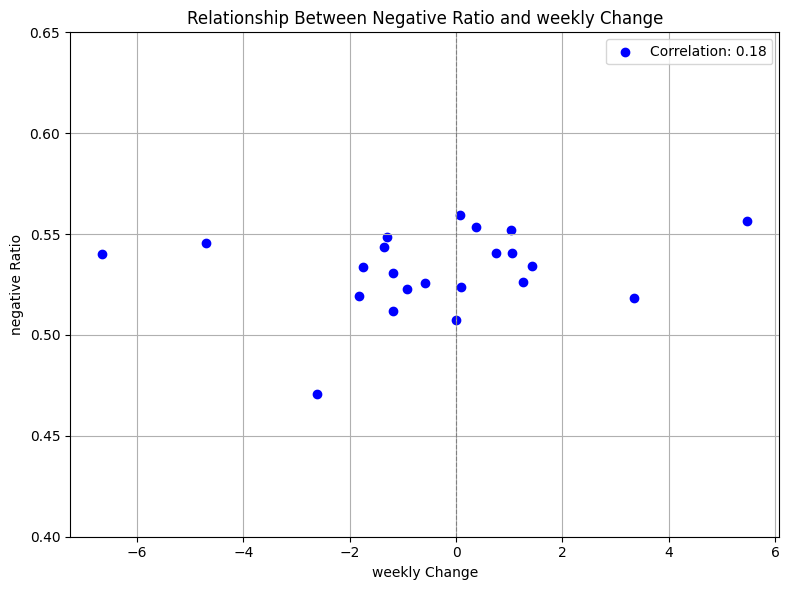

Correlation between Weekly Change and Negative Ratio: 0.18
Correlation between Weekly Change and Positive Ratio: -0.01


In [70]:
# יצירת עמודת שבוע
ta_35_all['week'] = ta_35_all['תאריך'].dt.to_period('W').apply(lambda r: r.start_time)
# חישוב ממוצעים שבועיים ל-negative_ratio ול-positive_ratio
weekly_ratios = ta_35_all.groupby('week')[['negativ_ratio', 'positive_ratio']].mean().reset_index()
# הוספת עמודת השינוי השבועי
weekly_changes = ta_35_all.groupby('week')['שינוי שבועי'].mean().reset_index()
# מיזוג הנתונים
weekly_data = pd.merge(weekly_ratios, weekly_changes, on='week')
# חישוב קורלציות
negative_correlation = weekly_data['negativ_ratio'].corr(weekly_data['שינוי שבועי'])
positive_correlation = weekly_data['שינוי שבועי'].corr(weekly_data['positive_ratio'])
#
plt.figure(figsize=(8, 6))
plt.scatter(weekly_data['שינוי שבועי'], weekly_data['negativ_ratio'], color='blue', label=f"Correlation: {negative_correlation:.2f}")
plt.title('Relationship Between Negative Ratio and weekly Change')
plt.xlabel('weekly Change')
plt.ylabel('negative Ratio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylim(0.4, 0.65) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# הצגת התוצאות
print(f"Correlation between Weekly Change and Negative Ratio: {negative_correlation:.2f}")
print(f"Correlation between Weekly Change and Positive Ratio: {positive_correlation:.2f}")


In [64]:
fb_hebrew_2020.to_excel('fb_hebrew_2020.xlsx', index=False)

,week,negativ_ratio,positive_ratio,שינוי שבועי
0,2019-12-30,0.553296,0.173570,0.379616
1,2020-01-06,0.523591,0.186977,0.084357
2,2020-01-13,0.540472,0.180190,0.743165
3,2020-01-20,0.526052,0.190230,1.266577
4,2020-01-27,0.530733,0.183397,-1.189295


In [9]:
fb_hebrew_2020_end.to_excel('fb_hebrew_2020_end.xlsx', index=False)

In [4]:
ta35_2020 = pd.read_excel("ta35_2020.xlsx") 
fb_hebrew_2020_end = pd.read_csv("fb_hebrew_2020_end")

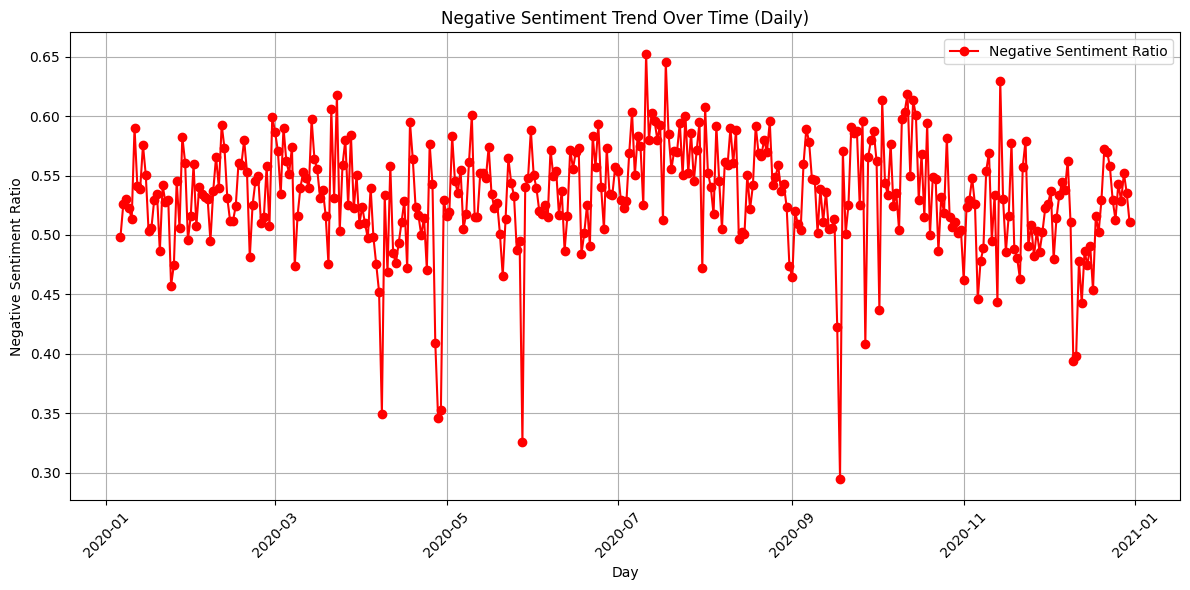

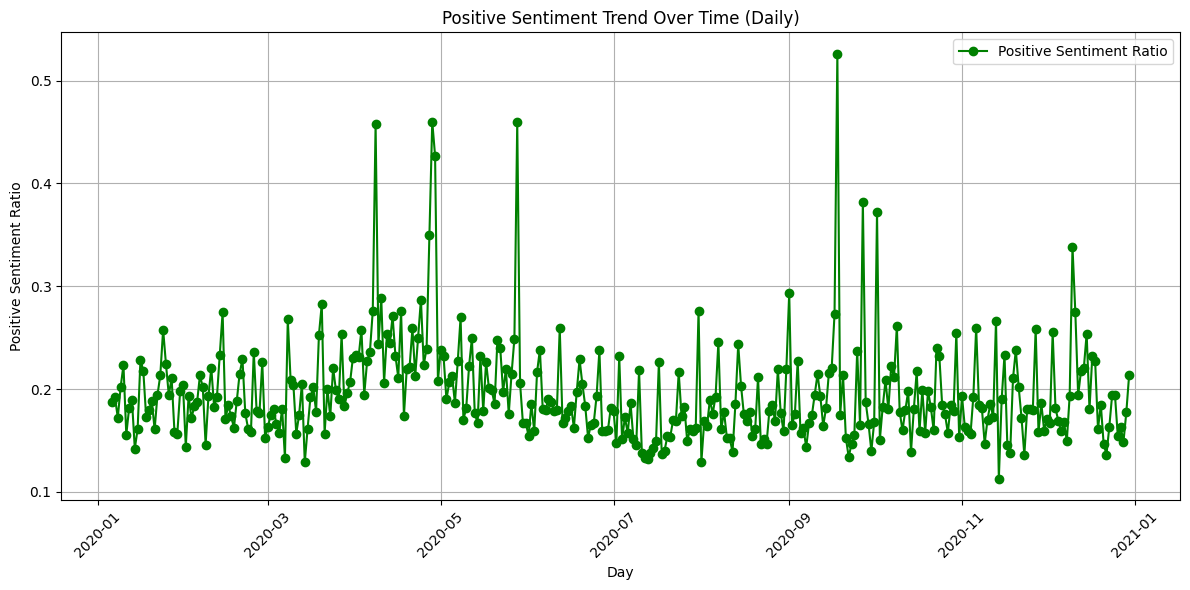

In [12]:
import matplotlib.pyplot as plt
# המרת עמודת התאריך לפורמט datetime (אם עדיין לא בוצע)
fb_hebrew_2020_end['date'] = pd.to_datetime(fb_hebrew_2020_end['date'])
# הוספת עמודת יום (העתק של עמודת התאריך ללא זמן)
fb_hebrew_2020_end['day'] = fb_hebrew_2020_end['date'].dt.date
# חישוב כמות הפוסטים לפי סנטימנט בכל יום
sentiment_counts_daily = fb_hebrew_2020_end.groupby(['day', 'adjusted_label']).size().unstack(fill_value=0)
# חישוב סך הפוסטים ויחסי הפוסטים החיוביים והשליליים
sentiment_counts_daily['total'] = sentiment_counts_daily.sum(axis=1)
sentiment_counts_daily['negative_ratio'] = sentiment_counts_daily['negative'] / sentiment_counts_daily['total']
sentiment_counts_daily['positive_ratio'] = sentiment_counts_daily['positive'] / sentiment_counts_daily['total']

# מיזוג עמודות היחסים עם הטבלה המקורית
fb_hebrew_2020_end = fb_hebrew_2020_end.merge(
    sentiment_counts_daily[['negative_ratio', 'positive_ratio']].reset_index(),
    how='left',
    left_on='day',
    right_on='day')
# גרף מגמת הפוסטים השליליים
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts_daily.index, sentiment_counts_daily['negative_ratio'], marker='o', label='Negative Sentiment Ratio', color='red')
plt.title('Negative Sentiment Trend Over Time (Daily)')
plt.xlabel('Day')
plt.ylabel('Negative Sentiment Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# גרף מגמת הפוסטים החיוביים
plt.figure(figsize=(12, 6))
plt.plot(sentiment_counts_daily.index, sentiment_counts_daily['positive_ratio'], marker='o', label='Positive Sentiment Ratio', color='green')
plt.title('Positive Sentiment Trend Over Time (Daily)')
plt.xlabel('Day')
plt.ylabel('Positive Sentiment Ratio')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [10]:
ta35_2020 = pd.read_excel("ta35_2020.xlsx") 

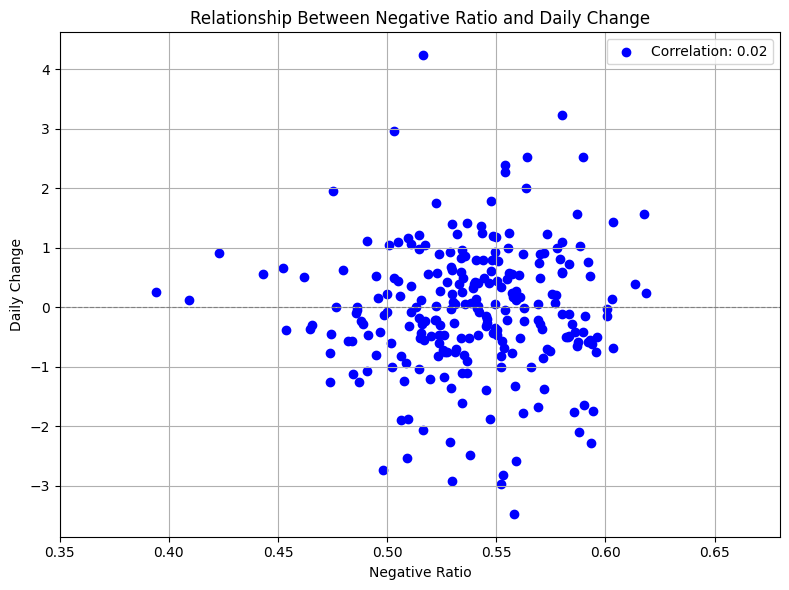

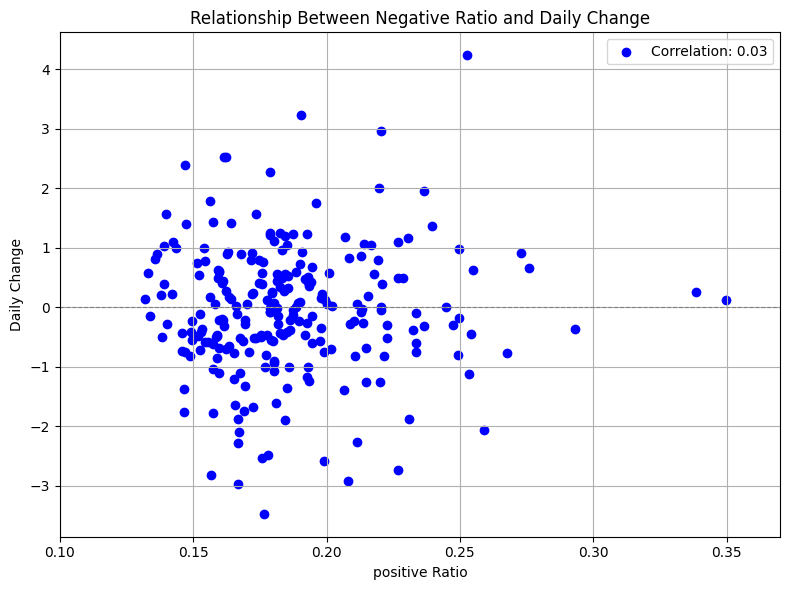

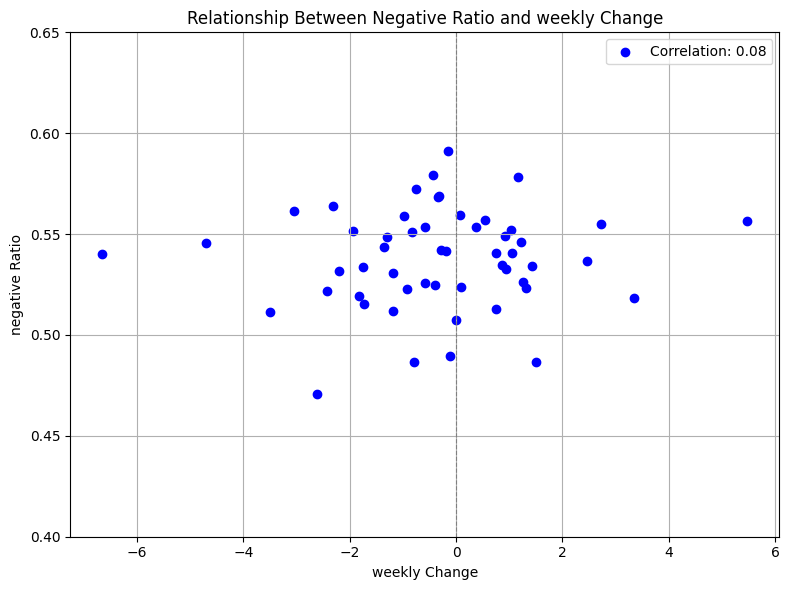

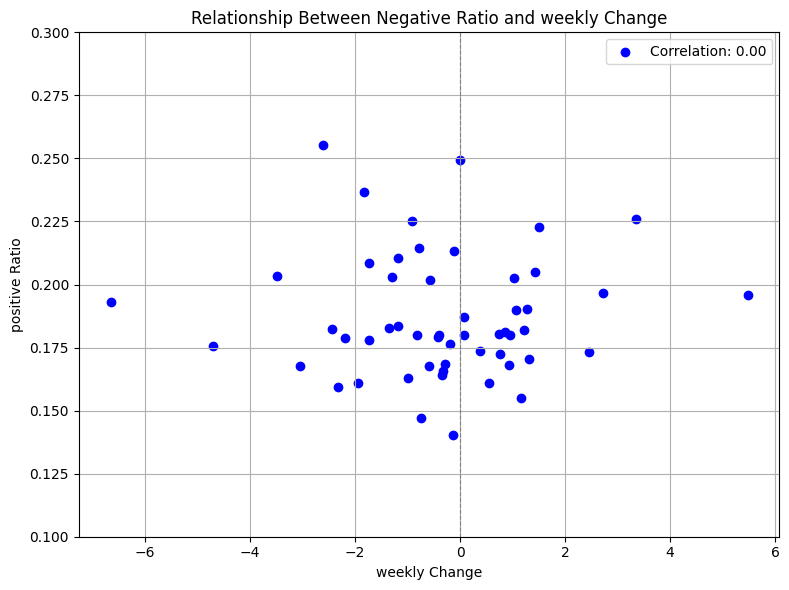

Correlation between Negative Ratio and Daily Change: 0.02
Correlation between Negative Ratio and Daily Change: 0.03
Correlation between Weekly Change and Negative Ratio: 0.08
Correlation between Weekly Change and Positive Ratio: 0.00


In [22]:
# חישוב קורלציה בין שינוי יומי ל-negative_ratio
correlation_n = ta35_2020['שינוי יומי'].corr(ta35_2020['negativ_ratio'])
correlation_p = ta35_2020['שינוי יומי'].corr(ta35_2020['positive_ratio'])
# יצירת גרף הקשר בין שינוי יומי ל-negative_ratio
plt.figure(figsize=(8, 6))
plt.scatter(ta35_2020['negativ_ratio'], ta35_2020['שינוי יומי'], color='blue', label=f"Correlation: {correlation_n:.2f}")
plt.title('Relationship Between Negative Ratio and Daily Change')
plt.xlabel('Negative Ratio')
plt.ylabel('Daily Change')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlim(0.35, 0.68) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#
plt.figure(figsize=(8, 6))
plt.scatter(ta35_2020['positive_ratio'], ta35_2020['שינוי יומי'], color='blue', label=f"Correlation: {correlation_p:.2f}")
plt.title('Relationship Between Negative Ratio and Daily Change')
plt.xlabel('positive Ratio')
plt.ylabel('Daily Change')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.xlim(0.1, 0.37) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# יצירת עמודת שבוע
ta35_2020['week'] = ta35_2020['תאריך'].dt.to_period('W').apply(lambda r: r.start_time)
# חישוב ממוצעים שבועיים ל-negative_ratio ול-positive_ratio
weekly_ratios = ta35_2020.groupby('week')[['negativ_ratio', 'positive_ratio']].mean().reset_index()
# הוספת עמודת השינוי השבועי
weekly_changes = ta35_2020.groupby('week')['שינוי שבועי'].mean().reset_index()
# מיזוג הנתונים
weekly_data = pd.merge(weekly_ratios, weekly_changes, on='week')
# חישוב קורלציות
negative_correlation = weekly_data['negativ_ratio'].corr(weekly_data['שינוי שבועי'])
positive_correlation = weekly_data['positive_ratio'].corr(weekly_data['שינוי שבועי'])
#
plt.figure(figsize=(8, 6))
plt.scatter(weekly_data['שינוי שבועי'], weekly_data['negativ_ratio'], color='blue', label=f"Correlation: {negative_correlation:.2f}")
plt.title('Relationship Between Negative Ratio and weekly Change')
plt.xlabel('weekly Change')
plt.ylabel('negative Ratio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylim(0.4, 0.65) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#positive_ratio & weekly change 
plt.figure(figsize=(8, 6))
plt.scatter(weekly_data['שינוי שבועי'], weekly_data['positive_ratio'], color='blue', label=f"Correlation: {positive_correlation:.2f}")
plt.title('Relationship Between Negative Ratio and weekly Change')
plt.xlabel('weekly Change')
plt.ylabel('positive Ratio')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.ylim(0.1, 0.3) 
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
# הצגת התוצאות
print(f"Correlation between Negative Ratio and Daily Change: {correlation_n:.2f}")
print(f"Correlation between Negative Ratio and Daily Change: {correlation_p:.2f}")
print(f"Correlation between Weekly Change and Negative Ratio: {negative_correlation:.2f}")
print(f"Correlation between Weekly Change and Positive Ratio: {positive_correlation:.2f}")

In [26]:
# סינון הנתונים עבור יחס שלילי גבוה
high_negative_changes = ta35_2020[ta35_2020['negativ_ratio'] > 0.6][['תאריך', 'שינוי יומי', 'שינוי שבועי', 'negativ_ratio']]
# סינון הנתונים עבור יחס חיובי גבוה
high_positive_changes = ta35_2020[ta35_2020['positive_ratio'] > 0.25][['תאריך', 'שינוי יומי', 'שינוי שבועי', 'positive_ratio']]
print(high_negative_changes)
print(high_positive_changes)


Daily and Weekly Changes with High Negative Ratio:
         תאריך  שינוי יומי  שינוי שבועי  negativ_ratio
56  2020-03-23    1.568787     2.662882       0.617580
84  2020-05-10   -0.154752     0.176387       0.600932
123 2020-07-06    1.436863     3.982971       0.603631
128 2020-07-13    0.144602    -0.906971       0.602959
188 2020-10-11   -0.683667    -0.034305       0.603687
189 2020-10-12    0.232940    -0.628164       0.618694
191 2020-10-14    0.395610    -0.361018       0.613470
192 2020-10-15   -0.036799    -0.445466       0.600583

Daily and Weekly Changes with High Positive Ratio:
         תאריך  שינוי יומי  שינוי שבועי  positive_ratio
46  2020-03-08   -0.775062    -6.460223        0.267833
54  2020-03-19    4.233526     4.032018        0.252721
67  2020-04-07    0.652680    -2.612802        0.275862
68  2020-04-12   -1.116268    -3.130717        0.253333
73  2020-04-21   -2.059830    -3.138465        0.259027
77  2020-04-27    0.113882     0.306133        0.349782
163 2020-0

In [13]:

financial_terms = [
    # מושגים כלליים
    'מניה', 'שוק ההון', 'אג"ח', 'בורסה', 'קרנות', 'השקעה', 'תשואה', 'מנייה',
    # מדדים מרכזיים
    'מדד תל אביב 125', 'מדד תל אביב 90', 'מדד ת"א 35', 'מדד ת"א 90', 'מדד ת"א 125',
    # מוצרים פיננסיים
    'קופת גמל', 'פוליסה', 'ביטוח מנהלים', 'קרן השתלמות', 'קרן נאמנות', 
    'קרן מחקה', 'קרן השקעות', 'אופציה', 'ETF', 'תעודת סל', 'תעודת חיסכון',
    # מאקרו ומיקרו כלכלה
    'אינפלציה', 'ריבית', 'גירעון', 'תוצר לאומי גולמי', 'תוצר מקומי גולמי', 
    'משכנתא', 'אשראי', 'חוב ציבורי', 'עקום ריבית',
    # רגולציה ומסים
    'מס הכנסה', 'מס שבח', 'פטור ממס', 'דיווח שנתי', 'רשות ניירות ערך', 
    'תקנות רגולציה', 'חובת דיווח',
    # מסחר
    'סוחר', 'מסחר יומי', 'ניתוח טכני', 'ניתוח פונדמנטלי', 'מחזור מסחר', 
    'תמיכה והתנגדות', 'שורט', 'לונג', 'מינוף',
    # חדשות כלכליות
    'דירוג אשראי', 'הורדת דירוג', 'תחזיות רווח', 'התחזקות הדולר', 
    'ירידת שערים', 'עלייה בשערים', 'עדכון תחזיות', 'שער חליפין',
    # מושגים יומיומיים
    'חיסכון', 'פנסיה', 'הכנסה פאסיבית', 'הכנסה אקטיבית', 'תקציב', 
    'הכנסה', 'הוצאה', 'ניהול סיכונים', 'עושר', 'ביטוח',
    # ביטויים ברשתות חברתיות
    'איך להשקיע', 'איזה מניה', 'המלצה חמה', 'להשקיע נכון', 
    'תחזית לשבוע הבא', 'פורום השקעות', 'הזדמנות קנייה', 'זמן למכור', 
    # קריפטו ומטבעות דיגיטליים
    'ביטקוין', 'אתריום', 'קריפטו', 'מטבע דיגיטלי', 'בלוקצ׳יין', 
    'טוקן', 'כרייה', 'NFT', 'חוזים חכמים', 'ארנק דיגיטלי'
]
# Filter rows that contain "טבע" or "הפועלים"
filtered_rows_fb_nature = fb_hebrew_2020_end[fb_hebrew_2020_end['message'].str.contains('טבע', na=False)]
filtered_rows_fb_poalim = fb_hebrew_2020_end[fb_hebrew_2020_end['message'].str.contains('הפועלים', na=False)]
filtered_rows_finance = fb_hebrew_2020_end[fb_hebrew_2020_end['message'].str.contains('|'.join(fr'\b{term}\b' for term in financial_terms), na=False)]

# Print the number of rows containing "טבע" and "הפועלים"
print(f"Number of rows containing 'טבע': {filtered_rows_fb_nature.shape[0]}") #'טבע: 975
print(f"Number of rows containing 'הפועלים': {filtered_rows_fb_poalim.shape[0]}")#'הפועלים: 207
print(f"Number of rows containing 'finance': {filtered_rows_finance.shape[0]}")#'הפועלים: 207


Number of rows containing 'טבע': 1715
Number of rows containing 'הפועלים': 153
Number of rows containing 'finance': 2201


In [14]:
filtere_finance.to_excel('filtere_finance.xlsx', index=False)


NameError: name 'filtere_finance' is not defined

In [1]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 110.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 100.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 88.8 MB/s eta 0:00:00


In [4]:
import pandas as pd 
ta35 = pd.read_csv("ta_35 2013-2020.csv")


In [11]:
ta35.head()

,תאריך,מדד פתיחה,מדד נעילה,מדד גבוה,מדד נמוך,שינוי יומי,שינוי שבועי,שינוי חודשי
0,2013-01-01,1206.53,1214.59,1214.59,1202.65,0.668031,NaN,NaN
1,2013-01-02,1218.60,1221.31,1223.53,1217.13,0.222386,NaN,NaN
2,2013-01-03,1216.79,1210.62,1217.45,1207.13,-0.507072,NaN,NaN
3,2013-01-06,1220.24,1216.39,1222.41,1215.90,-0.315512,NaN,NaN
4,2013-01-07,1213.90,1206.78,1214.46,1205.41,-0.586539,-0.518705,NaN


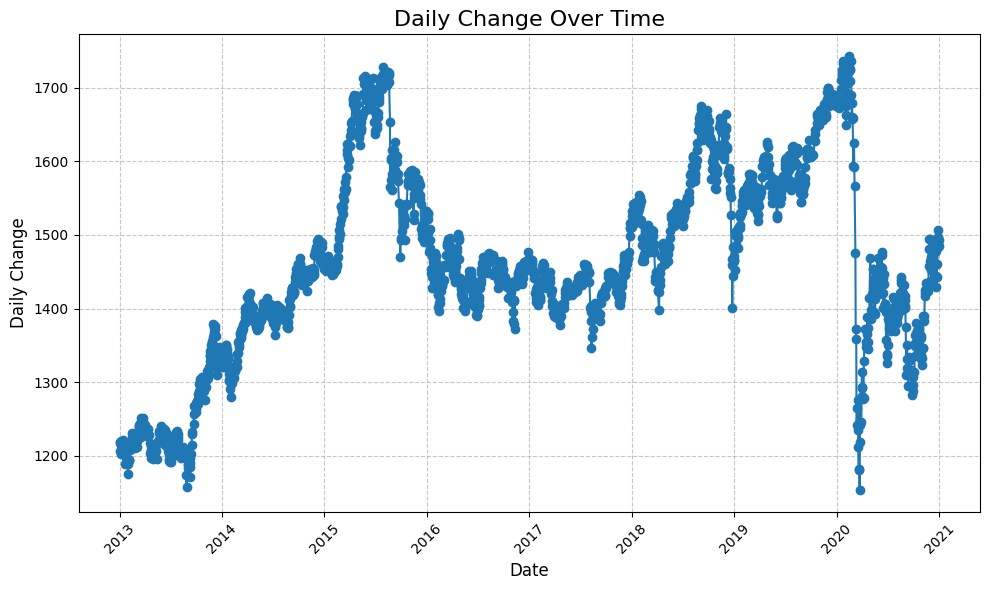

In [12]:
import matplotlib.pyplot as plt
ta35["תאריך"] = pd.to_datetime(ta35["תאריך"], format="%d/%m/%Y")
# Plotting daily changes over time
plt.figure(figsize=(10, 6))
plt.plot(ta35["תאריך"], ta35["מדד פתיחה"], marker="o", linestyle="-")
plt.title("Daily Change Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Change", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

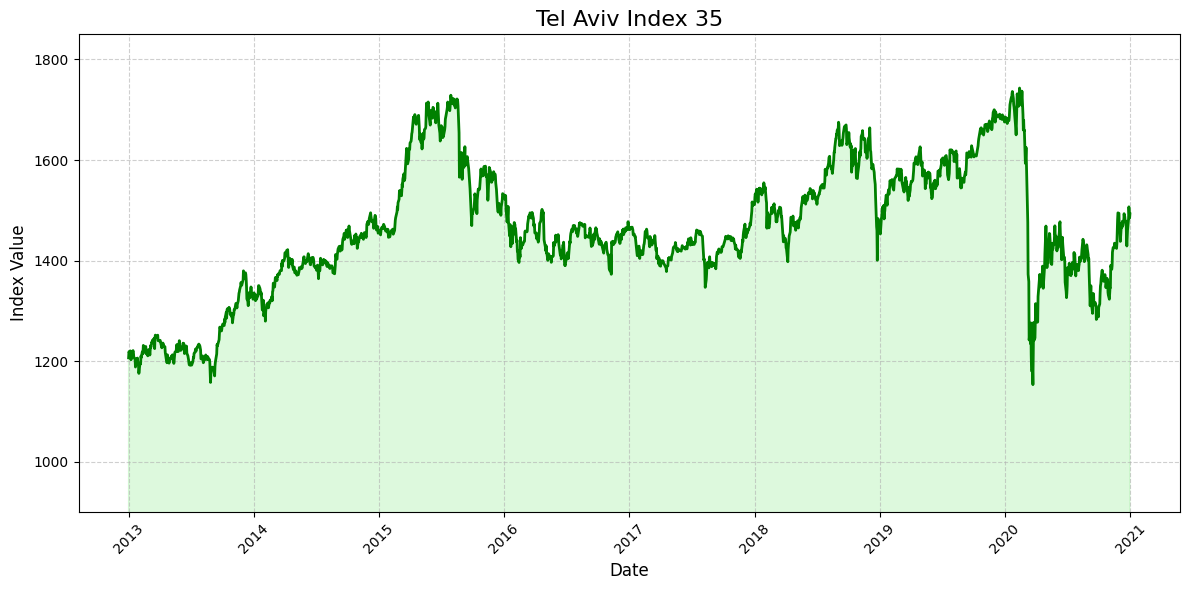

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ta35["תאריך"], ta35["מדד פתיחה"], color='green', linewidth=2)
plt.fill_between(ta35["תאריך"], ta35["מדד פתיחה"], color='lightgreen', alpha=0.3)  # Add shading under the line
plt.title("Tel Aviv Index 35", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Index Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(900,1850)
plt.tight_layout()
plt.show()

In [5]:
fb_hebrew_2014 = pd.read_excel("fb_hebrew_14_18.xlsx") 

In [6]:
fb_hebrew_2014.head()

,date,message,sentiment_scores,adjusted_sentiments,adjusted_label,adjusted_score
0,2014-01-01 22:29:16,הזוכה הגדול אלכס שולץ שגם צילם את עצמו ברגע ה...,NaN,NaN,NaN,NaN
1,2014-01-01 22:28:06,קבוצת הוותיקים ניצחה הערב 31 את וותיקי פתח תקו...,NaN,NaN,NaN,NaN
2,2014-01-01 22:25:37,ערבים מתפרעים ומשליכים אבנים בסמוך לקבר יוסף ב...,NaN,NaN,NaN,NaN
3,2014-01-01 22:08:25,וואלה סלבס עוד מנסה להירגע מחגיגות ליל אמש ואת...,NaN,NaN,NaN,NaN
4,2014-01-01 22:00:00,רתם איזק מעודדת אותך לחבק את הוויברטור ומגישה ...,NaN,NaN,NaN,NaN
